# Kaggle Titanic Data

1. 데이터 세트 학인 : null 값 체크 수정
2. 탐색적 데이타 분석(Exploratory Data Analysis) : 여러 feature들의 개별적 분석, 상관관계 확인, 시각화로 insights 얻기 위함
3. Feature Engineering : one-hot encoding, class 나누기, 구간나누기, 텍스트 데이타 처리등
4. Model 만들기 : sklearn을 사용, tensorflow, pytorch등도 사용
5. 모델 학습 및 예측: trainset으로 모델을 학습시킨후 testset으로 prediction
6. 모델 평가: 예측성능이 원하는 수준인지 판단

In [4]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn')
sns.set(font_scale=2.5)
#이 두줄은 필자가 항상 쓰는 방법입니다. matplotlib의 기본 scheme 말고 seaborn scheme을 세팅하고, 
# 일일이 graph의 font size를 지정할 필요가 없이 seaborn의 font_scale을 사용하면 편하다. 

import plotly.offline as py
py.init_notebook_mode(connected = True)
import plotly.graph_objs as go
import plotly.tools as tls

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

df_train = pd.read_csv('./data/titanic/train.csv')
df_test = pd.read_csv('./data/titanic/test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 # 자신을 더해야 하니 +1
df_test['FamilySize'] = df_test['SibSp'] + df_train['Parch'] + 1 # 자신을 더해야 하니 + 1

df_test.loc[df_test.Fare.isnull(),'Fare'] = df_test['Fare'].mean()

df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i>0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i>0 else 0)

## 3.Feature Engineering
* Null 값 채우기

### 3.1 Fill Null

#### 3.1.1 Fill Null in Age using title
Age fill null - Miss, Mr, Mrs Title 

In [5]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.') # lets extract the Salutations
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.') # lets extract the Salutations

In [6]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r') # Checking the Initials with the sex


Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


In [7]:
df_train['Initial'].replace(['Mlle','Mme','Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don','Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], regex=True, inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don','Dona'],
                            ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr','Mr'], regex=True, inplace=True)

In [8]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


<AxesSubplot:xlabel='Initial'>

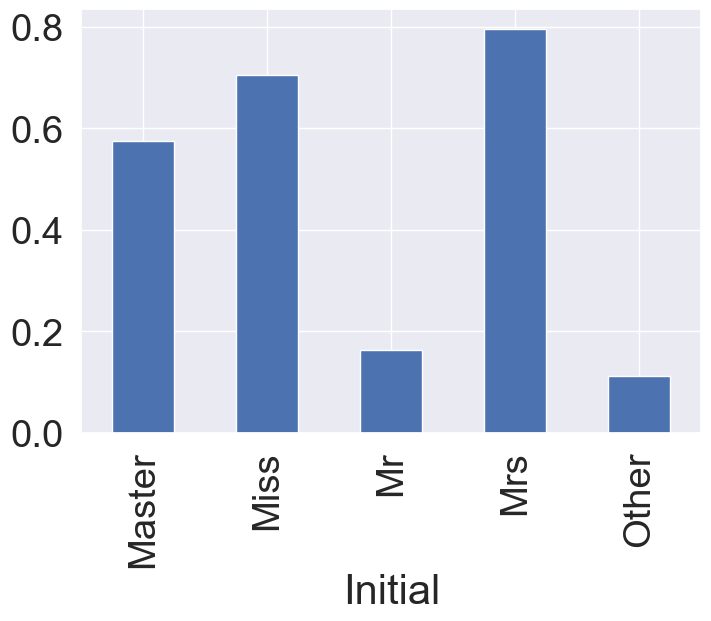

In [9]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

In [10]:
# Age 평균으로 null값 채우기

df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age']=33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age']=36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age']=5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age']=22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age']=46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age']=33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age']=36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age']=5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age']=22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age']=46



#### 3.1.2 Fill Null in Embarked

In [11]:
print('Embarked has', sum(df_train['Embarked'].isnull()),' Null values')

Embarked has 2  Null values


In [12]:
# Embarked null 값 2개 가장 많은 수 'S'로 채우자
df_train['Embarked'].fillna('S', inplace=True)

### 3.2 Change Age(Continuous to categorical)

In [13]:
#loc을 사용해서 Category화
df_train['Age_cat'] = 0
df_train.loc[df_train['Age']<10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age']<20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age']<30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age']<40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age']<50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age']<60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age']<70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'],'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age']<10, 'Age_cat'] = 0           
df_test.loc[(10 <= df_test['Age']) & (df_train['Age']<10),'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_train['Age']<20),'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_train['Age']<30),'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_train['Age']<40),'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_train['Age']<50),'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_train['Age']<60),'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'],'Age_cat'] = 1


In [14]:
#Apply 함수 적용
def category_age(x):
    if x < 10:
        return 0
    elif x <20:
        return 1
    elif x <30:
        return 2
    elif x <40:
        return 3
    elif x <50:
        return 4
    elif x <60:
        return 5
    elif x <70:
        return 6
    else:
        return 7
    
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

In [15]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함->',(df_train['Age_cat'] == df_train['Age_cat_2']).all())


1번 방법, 2번 방법 둘다 같은 결과를 내면 True 줘야함-> True


In [28]:
df_train.drop(['Age','Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

### 3.3 Change Initial, Embarked and Sex (string to numerical)

In [16]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

In [17]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [18]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [19]:
df_train['Embarked'] = df_train['Embarked'].map({'C':0, 'Q':1, 'S':2})
df_test['Embarked'] = df_test['Embarked'].map({'C':0, 'Q':1, 'S':2})

In [21]:
df_train['Embarked'].isnull().any()

False

In [22]:
df_train['Sex'] = df_train['Sex'].map({'female':0, 'male':1})
df_test['Sex'] = df_test['Sex'].map({'female':0, 'male':1})

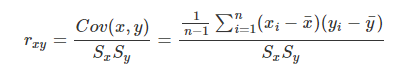

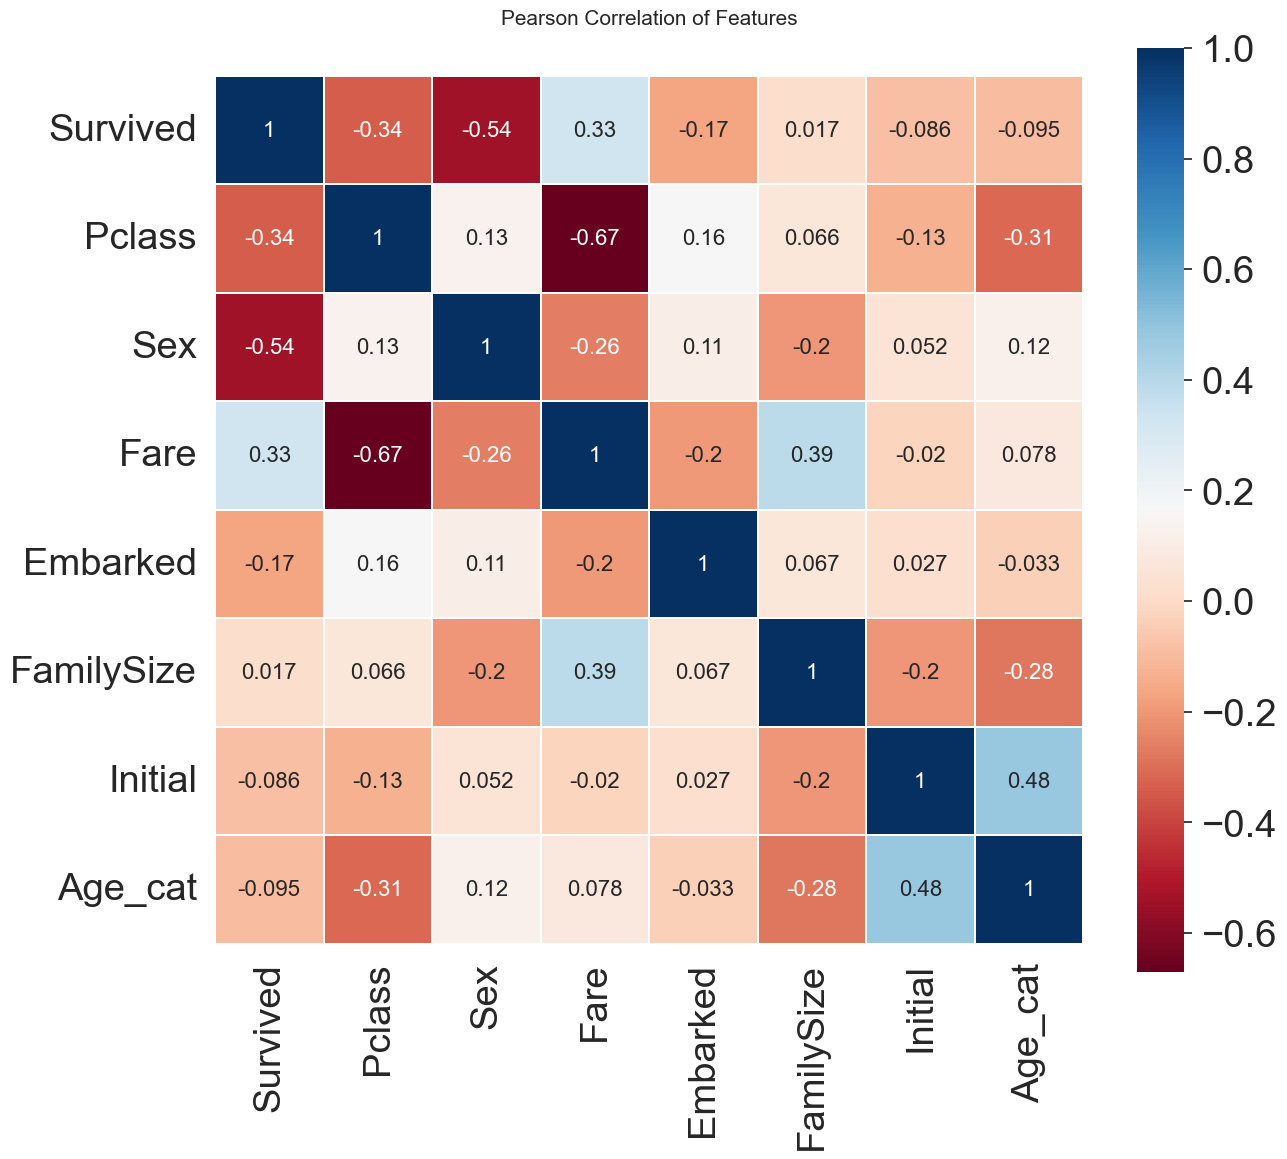

In [23]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize = (14, 12))
plt.title('Pearson Correlation of Features', y = 1.05, size = 15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap = colormap, linecolor='white', annot=True, annot_kws={"size":16})

del heatmap_data 

Observation
* Sex와 Pclass가 Survived에 어느 정도 상관 관계 있음
* 생각보다 Fare와 Embarked도 상관 관계가 있음
* 서로 강한 상관관계를 가지는 Feature들이 없다는 것
* 이것은 우리가 모델을 학습시킬 때 불필요한 (redundant, superfluous) feature가 없다는 뜻

### 3.4 One-hot encoding on Initial and Embarked

In [24]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [25]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Age_cat_2,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,NaN,2,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,C85,0,2,3,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,C123,2,2,3,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,NaN,2,1,3,3,0,0,1,0,0


In [26]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

In [27]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,Age_cat,Age_cat_2,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,1.981001,...,2,2,0,0,1,0,0,0,0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,4.266662,...,3,3,0,0,0,1,0,1,0,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,2.070022,...,2,2,0,1,0,0,0,0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,3.972177,...,3,3,0,0,0,1,0,0,0,1
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,2.085672,...,3,3,0,0,1,0,0,0,0,1


### 3.5 Drop columns

In [29]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [31]:
df_train.head(1)

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1


In [32]:
df_test.head(1)

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0.0,Initial_1.0,Initial_2.0,Initial_3.0,Initial_4.0,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.05786,1.0,3,0,0,1,0,0,0,1,0


## 4.Building machine learning model and prediction using the trained model

In [34]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier # 유명한 randomforestclassifier
from sklearn import metrics # 모델의 평가를 위해서 씁니다. 
from sklearn.model_selection import train_test_split # training set  을 쉽게 나눠주는 함수입니다. 

### 4.1 Preparatiion - Split dataset into train, valid, test set

In [35]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

In [36]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

### 4.2 Model generation and prediction

In [39]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

In [40]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction,y_vld)))

총 268명 중 82.46% 정확도로 생존을 맞춤


### 4.3 Feature importance

In [41]:
from pandas import Series

feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index = df_test.columns)

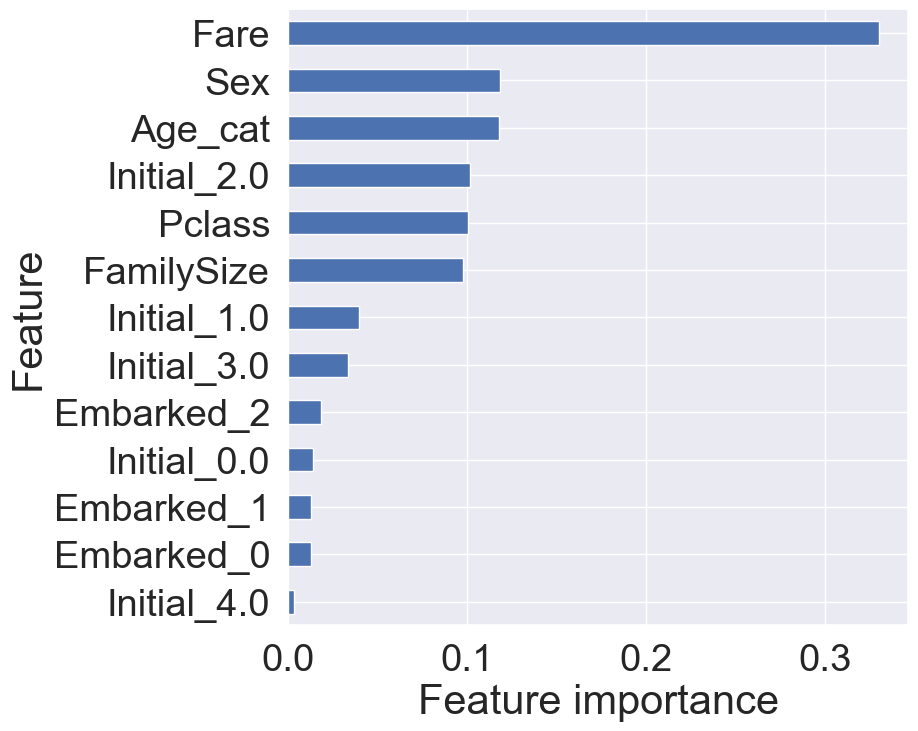

In [42]:
plt.figure(figsize=(8,8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

### 4.4 Prediction on Test set

In [43]:
submission = pd.read_csv('./data/titanic/gender_submission.csv')

In [44]:
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [45]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [46]:
submission.to_csv('./data/titanic/my_first_gender_submission.csv', index=False)

# 또 다른 처리들


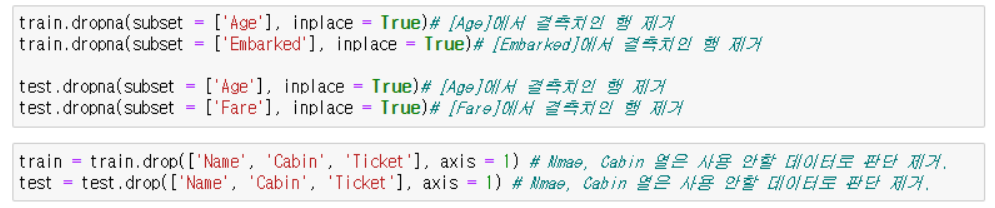

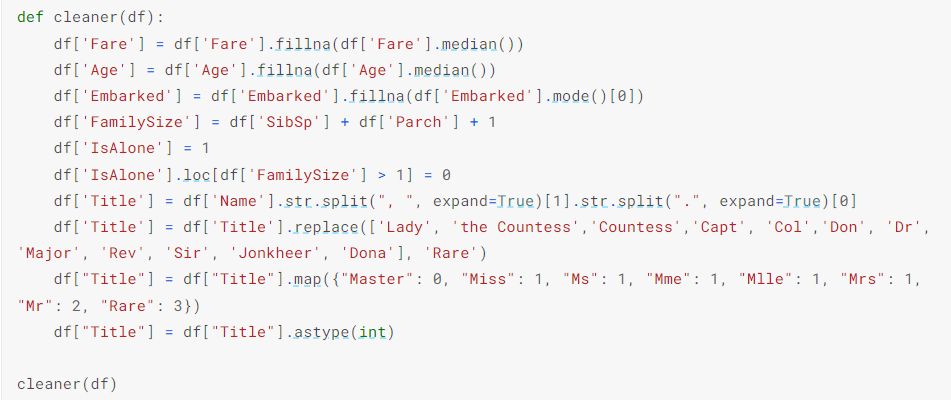

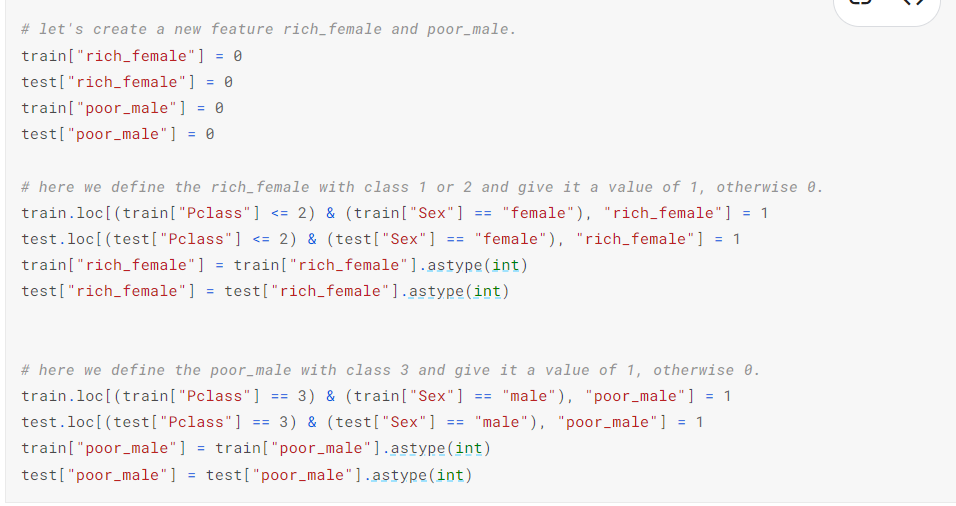